In [ ]:
## Este cell solo es para instalar los pkgs la primera vez, luego de la primera vez elimínenlo
using Pkg
pkgs = ["Plots" "PlotThemes" "ColorSchemes" "SparseArrays" "ToeplitzMatrices" "Statistics" "Distributions" "FFTW"]
Pkg.add.(pkgs)

In [27]:
using Plots, PlotThemes, ColorSchemes
using LinearAlgebra
using SparseArrays
using ToeplitzMatrices
using Statistics
using Distributions
using FFTW

theme(:juno)
default(fontfamily="times", titlefontsize=14, size=(900,400), palette=:seaborn_deep6, linewidth=2)

En primera instancia se define un vector de autocorrelación $\mathbf r = \left[r[0],\, \dots \,r[N-1]\right]$ arbitrario de longitud $N$.

In [28]:
N = 100
n = 0:N-1
r = [1.81; -0.9; 0.4] 
#r = [1.81; 0; -0.9; 0; 0.4]
#r = [1]
r = [r; zeros(N-length(r))];

El vector de autocorrelación $\mathbf r$ se usa para definir la matriz de covarianza de la distribución: $C = \begin{bmatrix} r[0]& r[1] & \cdots & r[N-1] \\ r[1]& r[0] & \cdots & r[N-2]\\ \vdots & \vdots & \ddots & \vdots \\ r[N-1] & r[N-2] & \cdots & r[0] \\ \end{bmatrix}$

In [29]:
C = SymmetricToeplitz(r) |> Matrix;

También se usa $\mathbf r$ para calcular la DEP del ruido, $\mathbf S = \mathcal F \{\mathbf r\}$. Para esto se necesita considerar la extensión par del $\mathbf r$ dado (si no queda cualquier cosa).

Ya que el algoritmo de la FFT considera que la señal temporal es periódica, se puede usar el siguiente truco para hacer la extensión par: $\mathbf r = \begin{bmatrix}r[0]& r[1] &r[2]  & \cdots & r[2] & r[1]\end{bmatrix}$

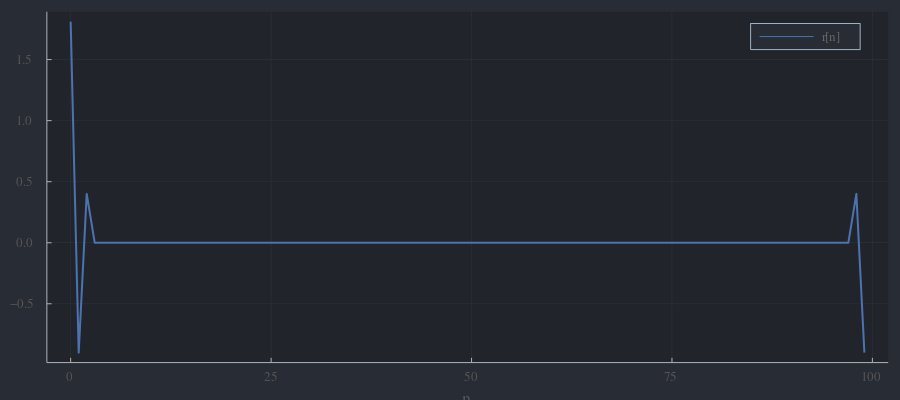

In [30]:
r = r .+ [0; r[end:-1:2]]
plot(n, r, xlabel="n", label="r[n]")

El vector de frecuencias para $N$ muestras se obtiene con `fftfreq`. Ya que la autocorrelación es par, sabemos que su transformada de fourier va a ser real y podemos tomar la parte real sin perder información.

Nota sintaxis: `f |> x` es sinónimo de `f(x)`

In [31]:
f = FFTW.fftfreq(N) |> fftshift       ## Vector de frecuencias
S = FFTW.fft(r) |> real |> fftshift;  ## DEP del ruido

Para hacer el barrido en frecuencias, se define una función que calcula la varianza del BLUE para una señal $s[n] = A \cos(2\pi f n)$, con amplitud normalizada tal que $E[s^2] = \langle s, s \rangle = s^T s = 1$ $$Var[\hat A]= \dfrac 1 {\mathbf s^T C^{-1} \mathbf s}$$

In [32]:
function normal_cos(f) 
    s = cos.(2*pi*f*n)       ## Cos de frecuencia f
    return s ./ sqrt(s'*s)   ## Normalización
end
blue_var(s) = 1/(s'*inv(C)*s)

fs = FFTW.fftfreq(1000) |> fftshift
V = blue_var.(normal_cos.(fs));

Nota de sintaxis: `f.(xs)` es sinónimo de `[f(x) for x in xs]`

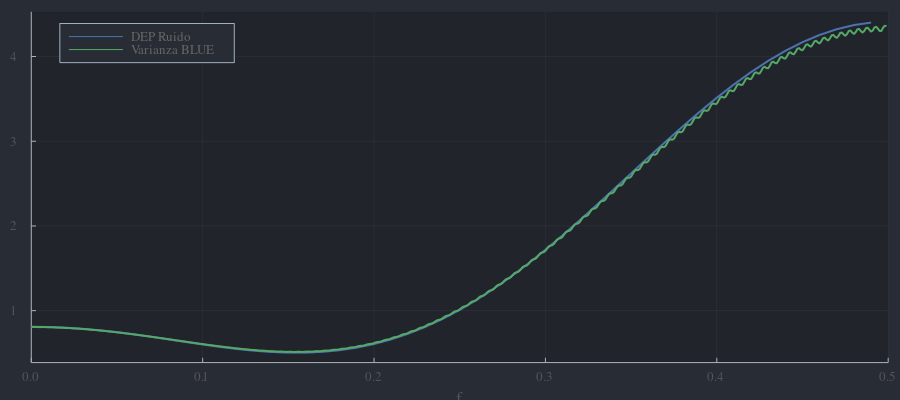

In [33]:
p1 = plot(xlabel="f", xlims=(0, 0.5), legend=:topleft)
plot!(p1, f, S, label="DEP Ruido")
plot!(p1, fs, V, label="Varianza BLUE")
plot(p1)

Es trivial encontrar la frecuencia $f$ que minimiza $Var[\hat A]$ empíricamente, usando `argmin`

In [34]:
fmin = fs[argmin(V)] |> abs
cos_min = normal_cos(fmin)
println("Valor que minimiza la varianza de A: f=$fmin con varianza Var = $(blue_var(cos_min))")

Valor que minimiza la varianza de A: f=0.153 con varianza Var = 0.5124266917023983


Los autovalores y autovectores se consiguen con la función `eigen`, de la forma $\lambda, \; M = \mathtt{eigen}(C)$

En donde $\lambda= \begin{bmatrix} \lambda_0 & \lambda_1 &\cdots &\lambda_{N-1}\end{bmatrix}$ son los autovalores y $M = \begin{bmatrix} \vec v_0 & \vec v_1 &\cdots &\vec v_{N-1}\end{bmatrix}$ es la matriz de sus correspondientes autovectores. El autovalor mínimo se encuentra nuevamente usando `argmin`.

In [35]:
λ, M = eigen(C)
eig_min = M[:, argmin(λ)];

Con esto podemos comparar la varianza del BLUE cuando la señal $\mathbf s$ es el autovector de autovalor mínimo de $C$

In [36]:
println("La varianza de A para el autovector de autovalor mínimo: Var = $(blue_var(eig_min))")

La varianza de A para el autovector de autovalor mínimo: Var = 0.5047636551236054


Podemos comparar el aspecto de la señal coseno de frecuencia óptima obtenido en el punto 1 contra el autovector óptimo de $C$ obtenido en el punto 2, en el dominio del tiempo y de la frecuencia

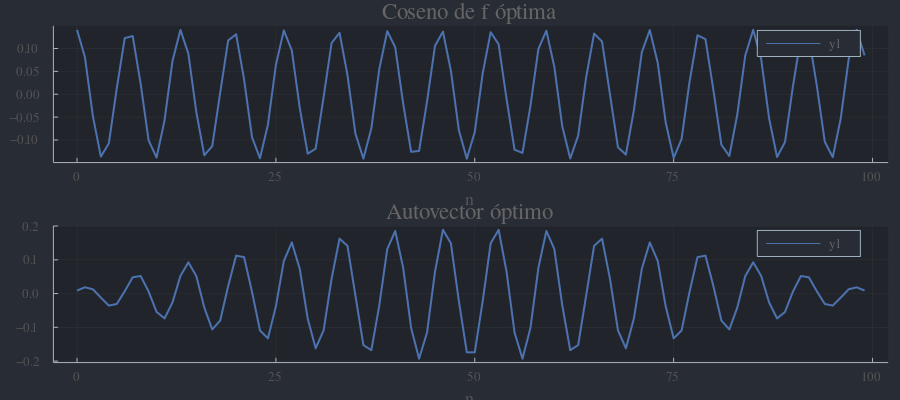

In [37]:
p1 = plot(n, cos_min, xlabel="n", title="Coseno de f óptima")
p2 = plot(n, eig_min, xlabel="n", title="Autovector óptimo")
plot(p1, p2, layout=(2,1))

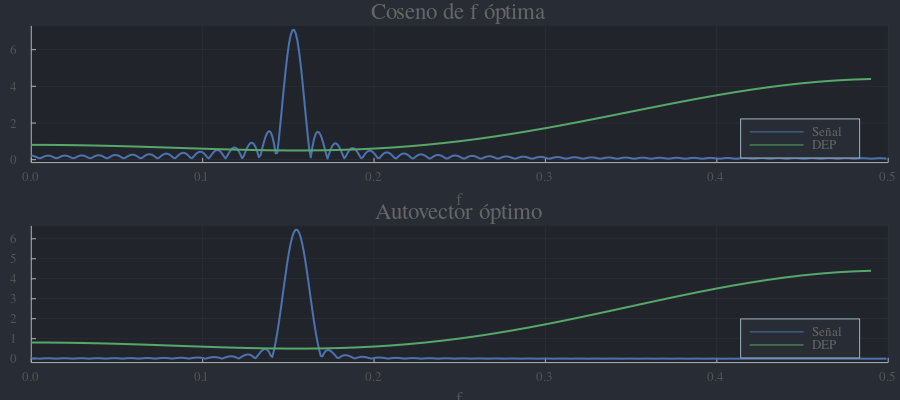

In [38]:
newlen = 1024
new_f = FFTW.fftfreq(newlen) |> fftshift 
S_cos = FFTW.fft([cos_min; zeros(newlen-N)]) |> fftshift;
S_eig = FFTW.fft([eig_min; zeros(newlen-N)]) |> fftshift;

p1 = plot(new_f, abs.(S_cos), legend=:bottomright, xlim=(0, 0.5), label = "Señal", xlabel="f", title="Coseno de f óptima")
p2 = plot(new_f, abs.(S_eig), legend=:bottomright, xlim=(0, 0.5), label = "Señal", xlabel="f", title="Autovector óptimo")
plot!(p1, f, S, label="DEP"); plot!(p2, f, S, label="DEP");

plot(p1, p2, layout=(2,1))

Notar: $M$ es la matriz de diagonalización de $C$, es decir, la matriz $A=M^{-1}CM$ es diagonal:

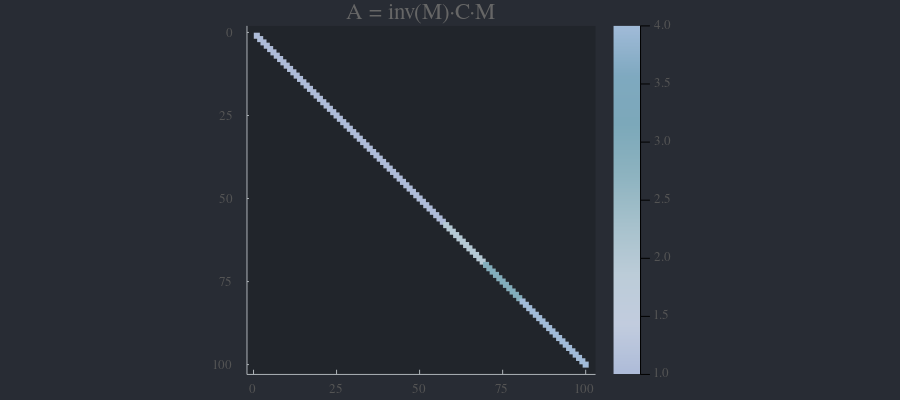

In [39]:
A = inv(M)*C*M
spy(A .|> round |> sparse, markersize=3, markershape=:square, title="A = inv(M)⋅C⋅M", c=cgrad(:aquamarine))

La matriz $M$  efectivamente blanquea el ruido de matriz de covarianza $C$, obteniendo la matriz de correlación ortogonalizada $A = \begin{bmatrix} \lambda_1& 0 & \cdots & 0 \\ 0& \lambda_2 & \cdots & 0\\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & \lambda_N \\ \end{bmatrix}$

Interpretacion: se puede considerar que cada autovector aporta una cierta cantidad de varianza al BLUE (idéntica a su autovalor). Esto se puede ver visualizando las señales en la base de autovectores. Usando la matriz cambio de base $M$ obtenemos una señal en la base de autovectores $$\mathbf s_B = M^{-1}\mathbf s = \sum_{i=1}^{N-1} \alpha_i \mathbf v_i$$

In [40]:
eig_min_B = inv(M)*eig_min;
cos_min_B = inv(M)*cos_min;

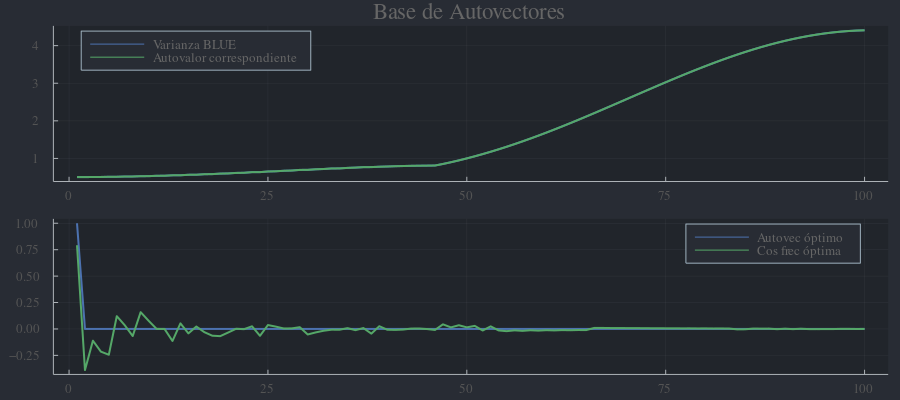

In [41]:
V_eig = blue_var.(eachcol(M))

p1 = plot(title="Base de Autovectores", legend=:topleft)
plot!(p1, V_eig, label="Varianza BLUE"); plot!(p1, λ, label = "Autovalor correspondiente")
p2 = plot()
plot!(p2, eig_min_B, label="Autovec óptimo")
plot!(p2, cos_min_B, label="Cos frec óptima")
plot(p1, p2, layout=(2,1))

Veamos el aspecto que tiene el denominador de la varianza del BLUE para una señal $\mathbf s$, transformando de la base temporal a la base de autovectores (esto es básicamente usar el teorema de Parseval)

$$\mathbf s^T C^{-1} \mathbf s = (M\mathbf s_B)^T(MAM^{-1})^{-1}M\mathbf s_B = \mathbf s_B^TA^{-1} \mathbf s_B = \begin{bmatrix} \alpha_1 & \alpha_2 & \cdots &  \alpha_N\end{bmatrix} \begin{bmatrix} \lambda_1^{-1}& 0 & \cdots & 0 \\ 0& \lambda_2^{-1} & \cdots & 0\\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & \lambda_N^{-1} \end{bmatrix} \begin{bmatrix} \alpha_1 \\ \alpha_2 \\ \vdots \\  \alpha_N\end{bmatrix} = \sum_{i=1}^{N}\frac{\alpha_i^2}{\lambda_i}$$

Esto demuesta el punto *6.8* del libro, y demuestra que la mínima varianza del BLUE posible ante ruido autocorrelacionado es para la señal $\mathbf s_B = \begin{bmatrix} 1 & 0 & \cdots & 0\end{bmatrix}$ en la base de autovectores de la matriz de correlación del ruido $C$

En resumen: Usamos la base temporal, la base de Fourier, y la base de autovectores para encontrar la señal que minimiza la varianza del BLUE en un canal que suma ruido correlacionado

Como queda una transmisión OOK optimizada en este canal: $[\mathtt 0 \rightarrow 0, \; \mathtt 1 \rightarrow \mathbf v_{min}]$

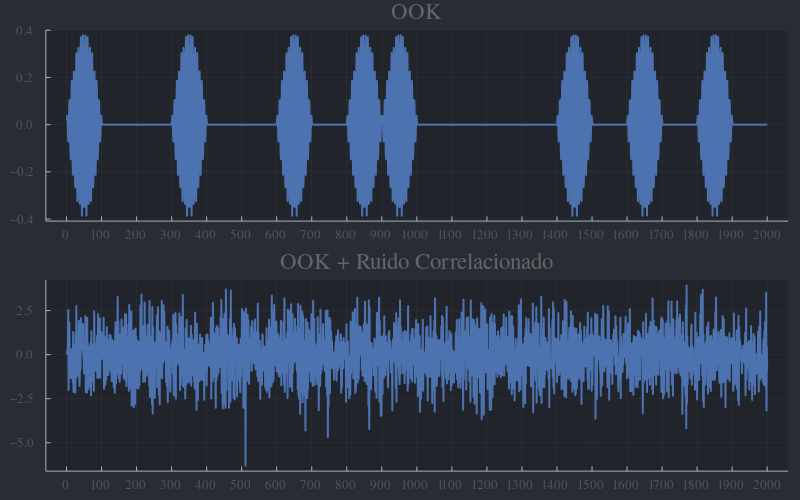

In [42]:
A = 2 ## A = 5 ## A = 2
s = eig_min

ook = Dict(0 => zeros(N), 1 => A*s)         ## Dicionario de codificación mensaje => señal transmitida
Ms = 20                                     ## Número de mensajes
msj = rand(0:1, Ms)                         ## Mensajes aleatorios binarios
d = MvNormal(zeros(N), C)                   ## Generador de ruido autocorrelacionado de media 0 y covarianza C 

tx = [ook[i]  for i in msj]
no = [rand(d) for i in msj]
rx = tx .+ no

p1 = plot(vcat(tx...), size=(800, 500), title="OOK", xticks=0:N:Ms*N, label=false)
p2 = plot(vcat(rx...), size=(800, 500), title="OOK + Ruido Correlacionado", xticks=0:N:Ms*N, label=false)

plot(p1, p2, layout=(2,1))

Y como queda el BLUE: $\displaystyle \hat A = \frac{\mathbf s^T C \mathbf x}{\mathbf s^T C \mathbf s}$, definimos la regla de decisión: $\begin{aligned}\hat A(x) < \tfrac 1 2 A \;\rightarrow\; \hat x =0\\ \hat A(x) > \tfrac 1 2 A \;\rightarrow\; \hat x = 1\end{aligned}$

In [43]:
BLUE(x) = s'*C*x/(s'*C*s)

dec(x) = BLUE(x) >= A/2 ? 1 : 0

println("Distancia a frontera: $(A/2), desvío estándar: $(blue_var(s) |> sqrt) \n")

for i in 1:Ms
    println("A = $(round(sqrt(tx[i]'tx[i]), digits=2)) \t BLUE = $(round(BLUE(rx[i]), digits=2)) \t x = $(msj[i]) \t y = $(dec(rx[i])) \t correcto: $(msj[i]==dec(rx[i]))")
end

Distancia a frontera: 1.0, desvío estándar: 0.7104672090417723 

A = 2.0 	 BLUE = 3.23 	 x = 1 	 y = 1 	 correcto: true
A = 0.0 	 BLUE = 0.05 	 x = 0 	 y = 0 	 correcto: true
A = 0.0 	 BLUE = 0.22 	 x = 0 	 y = 0 	 correcto: true
A = 2.0 	 BLUE = 1.82 	 x = 1 	 y = 1 	 correcto: true
A = 0.0 	 BLUE = 0.38 	 x = 0 	 y = 0 	 correcto: true
A = 0.0 	 BLUE = -1.81 	 x = 0 	 y = 0 	 correcto: true
A = 2.0 	 BLUE = 1.38 	 x = 1 	 y = 1 	 correcto: true
A = 0.0 	 BLUE = -1.21 	 x = 0 	 y = 0 	 correcto: true
A = 2.0 	 BLUE = 2.45 	 x = 1 	 y = 1 	 correcto: true
A = 2.0 	 BLUE = 1.46 	 x = 1 	 y = 1 	 correcto: true
A = 0.0 	 BLUE = 1.82 	 x = 0 	 y = 1 	 correcto: false
A = 0.0 	 BLUE = 0.84 	 x = 0 	 y = 0 	 correcto: true
A = 0.0 	 BLUE = -0.07 	 x = 0 	 y = 0 	 correcto: true
A = 0.0 	 BLUE = 0.06 	 x = 0 	 y = 0 	 correcto: true
A = 2.0 	 BLUE = 2.01 	 x = 1 	 y = 1 	 correcto: true
A = 0.0 	 BLUE = 0.74 	 x = 0 	 y = 0 	 correcto: true
A = 2.0 	 BLUE = 2.18 	 x = 1 	 y = 1 	 correcto: t